In [1]:
import numpy as np
import pandas as pd
import json
import os
import shutil
import subprocess as sp
import pyautogui as pg
import timeit
import time
from matplotlib import pyplot as plt
from model import Model, read_from_doc, write_to_doc
import h5py
import sys

### Fecundity

Hows about fecundity

/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_48085/595702587.py:8: RuntimeWarning: invalid value encountered in divide
  fecundity_err = fecundity * np.sqrt((prefire_density_se/prefire_density)**2 + (rec_density_se/rec_density)**2)


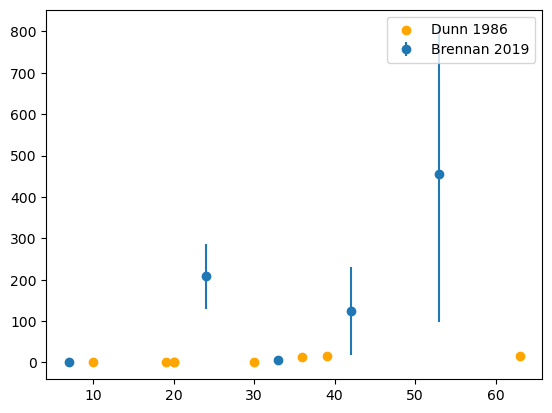

In [12]:
# Brennan 2019
stand_age = np.array([7,24,33,42,53])
prefire_density = np.array([2205,48,3430,233,400])
prefire_density_se = np.array([35,14,308,136,240])
rec_density = np.array([0,10000,18500,29000,182000])
rec_density_se = np.array([0,2345,9385,18443,92000])
fecundity = rec_density / prefire_density
fecundity_err = fecundity * np.sqrt((prefire_density_se/prefire_density)**2 + (rec_density_se/rec_density)**2)
plt.errorbar(stand_age, fecundity, yerr=fecundity_err, fmt='o', label='Brennan 2019')

# Dunn 1986
stand_age = [10,19,20,20,30,36,39,63]
fecundity = (np.array([0,0.1,2.9,26.5,15.7,1206.5,1387.3,1400]) / 100) + 1
plt.scatter(stand_age, fecundity, color='orange', label='Dunn 1986')

# Dunn 1984
# stand_age = [36,39]
# fecundity = (np.array([1206.5,1387.3]) / 100) + 1; fecundity
# plt.scatter(stand_age, fecundity, color='orange', label='Dunn 1984')

plt.legend()

### Mortality

#### Finding reasonable function for new model

Here's what the survival rate looks like over ages x from the old model (Regan 2012)

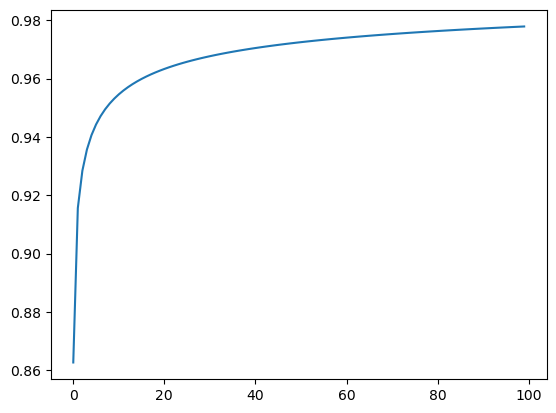

In [2]:
x = np.arange(100)
a = 17; b = 0.675
Sx = np.exp((x/a)**b - ((x+1)/a)**b)
plt.plot(Sx)

Now convert it to mortality (just 1 minus survival) and find a reasonably well fitting function. Looks like a simple exponential won't do the job.

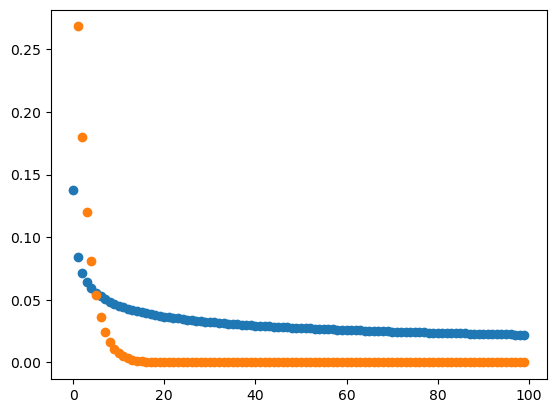

In [3]:
plt.scatter(x,1-Sx)
lam = 0.4
plt.scatter(x[1:],lam*np.exp(-lam*x[1:]))

Weibull function doesn't fit well either. The problem is that these normalized distributions asymptote to zero, whereas we want a mortality to bottom out at a minimum but nonzero value. 

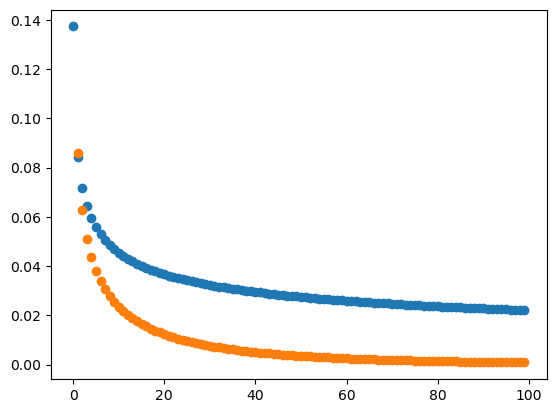

In [4]:
plt.scatter(x,1-Sx)
a = 17; b = 0.675
norm = (b/a) * (x[1:]/a)**(b-1)
plt.scatter(x[1:],norm*np.exp(-(x[1:]/a)**b))

But, I **think** it's fine if the mortality function isn't normalized. Intuitively it doesn't make sense for mortality to decrease to zero. I think as long as mortality is always less than 1, as this is the rate per individual, we're fine. When it get's translated to a binomial probability, we take e^(-mortality), so it will never be greater than 1.

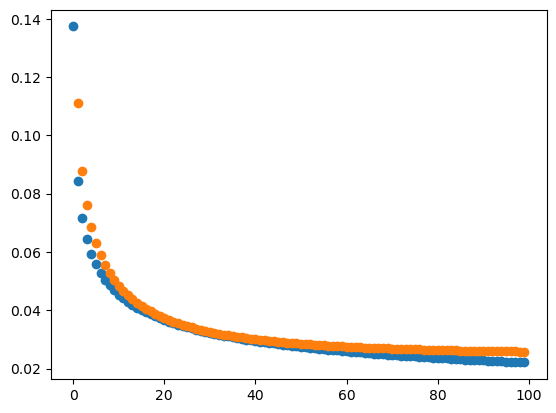

In [5]:
plt.scatter(x,1-Sx)
a = 17; b = 0.675; c = 0.025
norm = (b/a) * (x[1:]/a)**(b-1)
plt.scatter(x[1:],norm*np.exp(-(x[1:]/a)**b) + c)

#### The new data

In [2]:
df = pd.read_excel('AACypress_Full.xlsx')
df_sub = df[df['SPECIESCODE'] == 'Cupfor']
tstar_vec = np.array([1,2,5])
unitid_vec = np.unique(np.array(df['UNITID']))
plot_vec = np.unique(np.array(df['PLOT']))
density_vec = np.array(np.broadcast_to(np.array([np.nan for tstar in tstar_vec]), (len(plot_vec), len(tstar_vec))))

fire_year = 2003

for plot in plot_vec:
    for tstar_i, tstar in enumerate(tstar_vec):
        year = fire_year + tstar
        counts = df_sub[(df_sub['YEAR'] == year) & (df_sub['PLOT'] == plot)]['TOTALIN']
        density_vec[plot-1][tstar_i] = counts.sum()*1e2

Text(0.5, 0, 'time since last fire [years]')

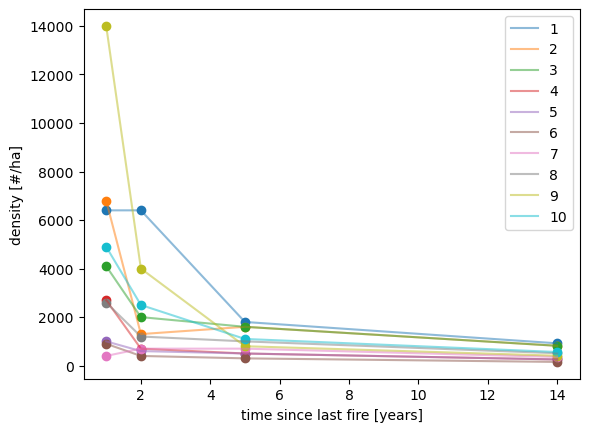

In [3]:
estimate_final = True
if estimate_final:
    tstar_vec = np.append(tstar_vec, 14)
    # Attempt 1
    # init_density = np.array([10000,18500,29000,182000])
    # final_density = np.array([606,6788,11745,22562])
    # scale = np.mean(final_density) / np.mean(init_density)
    # estimated = np.zeros((len(plot_vec),1))
    # for i, val in enumerate(density_vec[:,0]): 
    #     estimated[i][0] = scale*val
    # density_vec = np.hstack((density_vec, estimated))
    
    # Attempt 2
    mortality_yr2_avg = np.mean([-1*(density_vec[plot-1][1] - density_vec[plot-1][0]) / density_vec[plot-1][0] for plot in plot_vec])
    mortality_yr5_avg = np.mean([-1*(density_vec[plot-1][2] - density_vec[plot-1][1]) / density_vec[plot-1][1] for plot in plot_vec])
    init_density = np.array([10000,18500,29000,182000]) #From table 1
    final_density = np.array([606,6788,11745,22562])
    estimated_yr5_density = init_density * mortality_yr2_avg * (4*mortality_yr5_avg)
    scale = np.mean(final_density / estimated_yr5_density)
    estimated = np.zeros((len(plot_vec),1))
    for i, val in enumerate(density_vec[:,2]): 
        estimated[i][0] = scale*val
    density_vec = np.hstack((density_vec, estimated))

    # Attempt 3
    # mortality_yr2_avg = np.mean([-1*(density_vec[plot-1][1] - density_vec[plot-1][0]) / density_vec[plot-1][0] for plot in plot_vec])
    # init_density = np.array([10000,18500,29000,182000]) #From table 1
    # final_density = np.array([606,6788,11745,22562])
    # estimated_yr2_density = init_density * mortality_yr2_avg 
    # scale = np.mean(final_density / estimated_yr2_density)
    # estimated = np.zeros((len(plot_vec),1))
    # for i, val in enumerate(density_vec[:,1]): 
    #     estimated[i][0] = scale*val
    # density_vec = np.hstack((density_vec, estimated))
x = tstar_vec
for plot in plot_vec:
    y = density_vec[plot-1]
    plt.scatter(x,y)
    plt.plot(x,y,alpha=0.5,label=plot)
plt.legend()
plt.ylabel('density [#/ha]')
plt.xlabel('time since last fire [years]')

In [6]:
mortality_vec = np.array(np.broadcast_to(np.array([np.nan for tstar in tstar_vec[:-1]]), (len(plot_vec), len(tstar_vec[:-1]))))
for plot in plot_vec:
    for tstar_i, tstar in enumerate(tstar_vec):
        year = fire_year + tstar
        if tstar_i > 0:
            # Calculate density change relative to initial
            delta_t = tstar - tstar_vec[tstar_i-1]
            # On year 2 we only want to count trees that were present in year 1, labeled as resprouts
            '''On second thought I don't think we want to do this, whatever effect these 2nd year
               fecundity pulses have we want wrapped into the mortality rates, unless we decide to 
               incorporate the 2nd year pulse in fecundity explicitly.'''
            # if tstar == 2:
            #     counts = df_sub[(df_sub['YEAR'] == year) & (df_sub['GROWTHFORM'] == 'Resprout') & (df_sub['PLOT'] == plot)]['TOTALIN']
            #     density = counts.sum()*1e2
            #     prop_density_change = (density - density_vec[plot-1][tstar_i-1]) / density_vec[plot-1][tstar_i-1]
            # else:
            if True:
                prop_density_change = (density_vec[plot-1][tstar_i] - density_vec[plot-1][tstar_i-1]) / density_vec[plot-1][tstar_i-1]
            mortality = (-1 * prop_density_change) / delta_t
            mortality_vec[plot-1][tstar_i-1] = mortality

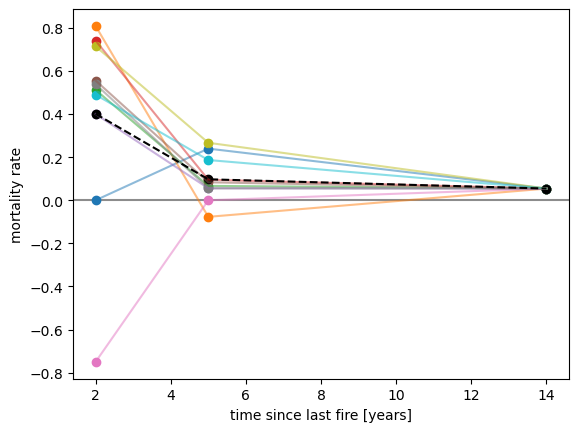

In [7]:
mean_mortality_vec = np.mean(mortality_vec, axis=0)
for plot in plot_vec:
    x = tstar_vec[1:]
    plt.scatter(x,mortality_vec[plot-1])
    plt.plot(x,mortality_vec[plot-1], alpha=0.5)
plt.scatter(x,mean_mortality_vec, color='black')
plt.plot(x,mean_mortality_vec, ls='--', color='black')
plt.ylabel('mortality rate')
plt.xlabel('time since last fire [years]')
plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')

### Density dependence

#### Playing with functional form

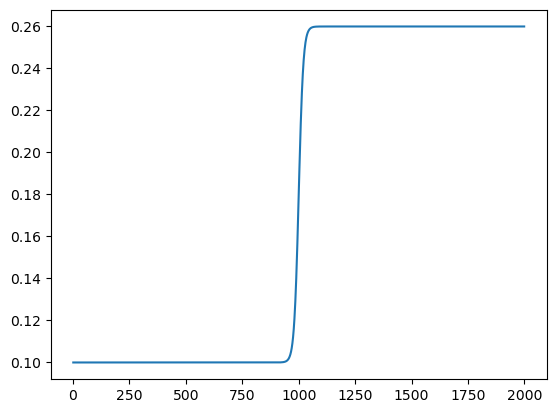

In [114]:
N = np.arange(1,2000,1); N
m_min_t = 0.1
m_max_t = m_min_t * 1.6
r = 0.1
K_t = 1000
m = m_min_t + m_max_t / (1+np.exp(-r*(N-K_t)))
plt.plot(N,m)

#### Looking at the data
Run mortality cells first

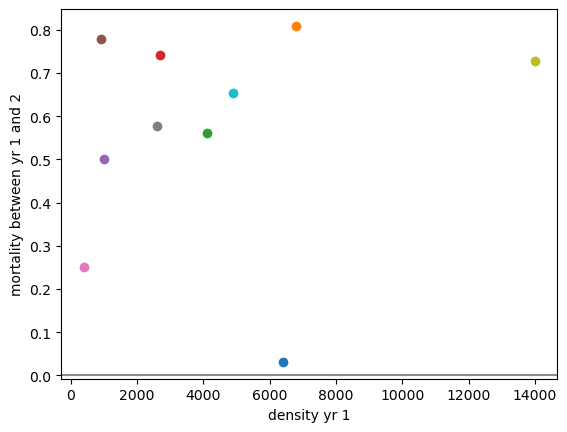

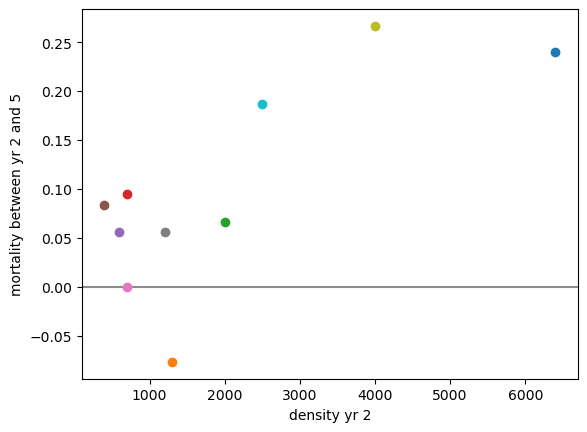

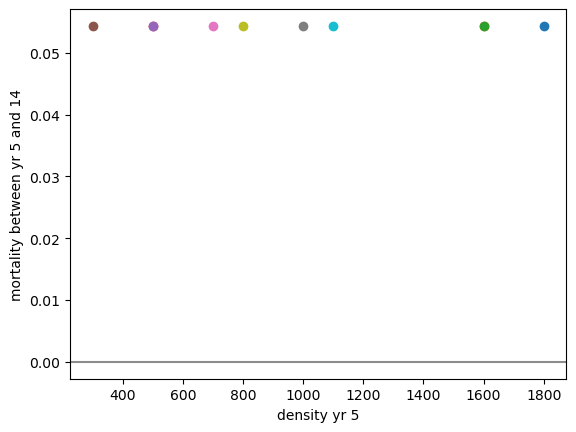

In [15]:
for tstar_i, tstar in enumerate(tstar_vec[:-1]):
    for plot in plot_vec:
        # Try correcting for second year birth pulse
        if tstar == 1:
            year = fire_year + tstar
            # print(year, year+1, plot)
            counts_yr2 = df_sub[(df_sub['YEAR'] == year+1) & (df_sub['GROWTHFORM'] == 'Resprout') & (df_sub['PLOT'] == plot)]['TOTALIN']
            density_yr2 = counts_yr2.sum()*1e2
            # print(density_vec[plot-1][tstar_i], density_yr2)
            corrected_mortality = -1*(density_yr2 - density_vec[plot-1][tstar_i]) / density_vec[plot-1][tstar_i]
            plt.scatter(density_vec[plot-1][tstar_i], corrected_mortality)
        else:
            plt.scatter(density_vec[plot-1][tstar_i], mortality_vec[plot-1][tstar_i])
    plt.axhline(0,ls='-',alpha=0.45,zorder=-1, color='black')
    plt.ylabel('mortality between yr {} and {}'.format(tstar, tstar_vec[tstar_i+1]))
    plt.xlabel('density yr {}'.format(tstar))
    plt.show()